In [12]:
import pickle
import os
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import options
import expectations
import iterators
import utils as ut

In [13]:
# numpy seed setup
seed = 29
np.random.seed(seed)

In [14]:
############# run parameters ###############
run_id = 'butterfly_sub_alpha_1'
S0 = 1.
alpha = 1.  # risk aversion parameter
bf_level = 0.1 # higher payoff of the butterfly option
sigma0 = .20 # central volatility (absolute)
uncertainty = 0.03 # uncertainty in the volatility (absolute) - volatility range [sigma0 - u,sigma0 + u] 
m = .05   # drift of the process (absolute)
T = .5 # maturity
step_nr = 100 # steps in the discretization
delta_x = 0.01 # step size of the spatial discretization
opt_method = 'Nelder-Mead'
drop_optim = True # set to True to save the plots of the optimizers at each step

In [15]:
# expectation factory
def make_expect():
    return expectations.sub_binomial_model(sigma_l=sigma0 - uncertainty, sigma_u=sigma0 + uncertainty, opt_method=opt_method)

# defining the risk measure
step_size = T / step_nr
rho_theta = expectations.RhoTheta(alpha=alpha, m=m, t=step_size)

# defining the option
option = options.ButterflyOption(strike=S0, level=bf_level)

In [16]:
# defining the spatial grid
error_propagation = np.absolute(m) * T + (sigma0 + uncertainty) * np.sqrt(T * step_nr)
print(f"Error propagation from the bounds of the space interval: {error_propagation:.3f}")

# initializing the space discretization for the optimization
x_levels = S0 + np.arange(-.25 - error_propagation, .26 + error_propagation, delta_x)
print(f"Range of the space discretization: [{np.round(x_levels[0], 3)}, {np.round(x_levels[-1], 3)}]. Discretization step: {np.round(x_levels[1] - x_levels[0], 3)}. Number of points: {x_levels.shape[0]}")

# initializing the space discretization for the fine interpolation
x_fine = S0 + np.arange(-.25 - error_propagation, .25 + error_propagation, 0.001)
print(f"Range of the fine space discretization: [{np.round(x_fine[0], 3)}, {np.round(x_fine[-1], 3)}]. Discretization step: {np.round(x_fine[1] - x_fine[0], 3)}. Number of points: {x_fine.shape[0]}")

# plot coordinates
x_plot = S0 + np.arange(-.25, .26, 0.01)

Error propagation from the bounds of the space interval: 2.325
Range of the space discretization: [-1.575, 3.575]. Discretization step: 0.01. Number of points: 516
Range of the fine space discretization: [-1.575, 3.574]. Discretization step: 0.001. Number of points: 5150


In [17]:
# performing the iteration
iter_dict, theta_dict, expect_dict = iterators.unc_iterations(x_levels=x_levels, x_fine=x_fine, option=option, step_nr=step_nr, rho_theta=rho_theta, make_expect=make_expect)

In [18]:
# setting latex style for plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 13

Plotting the resulting approximated $S(T)f$.

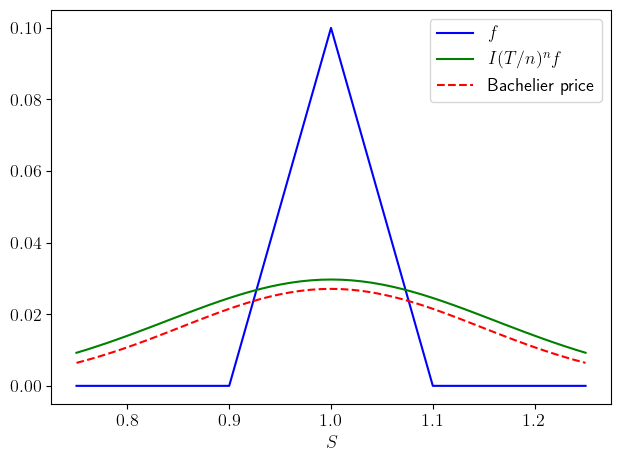

In [19]:
bachelier_levels = option.bachelier_price(x_plot, T, sigma0 * S0)
model_levels = np.interp(x_plot, x_fine, iter_dict[step_nr])

plt.plot(x_plot, option.payoff(x_plot), color='blue', label=f'$f$')
plt.plot(x_plot, model_levels, color='green', label=r'$I(T/n)^nf$')
plt.plot(x_plot, bachelier_levels, color='red', linestyle='--', label=f'Bachelier price')
plt.xlabel('$S$')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
if drop_optim:
    # checking (or creating) the output folder
    plots_dir = os.path.join(os.path.pardir,'output', run_id, 'optimizers')
    ut.check_dir(plots_dir)

    # plotting the hedging strategy and the worst-case volatility at each step of the iteration
    for i in range(1, step_nr + 1):

        hedging = np.interp(x_plot, x_levels, theta_dict[i])
        wc_vol = np.interp(x_plot, x_fine, expect_dict[i].vol_opt)

        fig, ax1 = plt.subplots()
        # plotting the first variable on the left axis
        ax1.plot(x_plot, hedging, color='tab:blue')
        ax1.set_xlabel('$S$')
        ax1.set_ylabel(r'$\theta^*$', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        # creating a second axis (right side) sharing the same x-axis
        ax2 = ax1.twinx()
        # plotting the second variable on the right axis
        ax2.plot(x_plot, wc_vol, color='tab:orange', linestyle='--')
        ax2.set_ylabel(r'$\sigma^*$', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, f'iteration_{i:3d}.png'), bbox_inches='tight')
        plt.close()

In [22]:
# saving the trading strategy and the iterations for later use
dict_dir = os.path.join(os.path.pardir,'output', run_id)
out_dict = {
    "option": option,
    "maturity": T,
    "step_nr": step_nr,
    "training_model": make_expect().model,
    "delta_x": delta_x,
    "optim method": opt_method, 
    "x_theta": x_levels,
    "theta_trained": theta_dict,
    "x_I": x_fine,
    "I_trained": iter_dict
}

# checking (or creating) the output folder
out_dir = os.path.join(os.path.pardir,'output', run_id)
ut.check_dir(out_dir)

# Save the dictionary to a pickle binary file
with open(os.path.join(dict_dir,'trained_model.pkl'), 'wb') as pickle_file:
    pickle.dump(out_dict, pickle_file)